In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set seed
np.random.seed(0)

In [18]:
# dataset genration (for and, or, xor)
def generate_data(n, noise=0.5):
    X = np.random.rand(n, 2)
    X_noise = np.random.normal(0, noise, (n, 2))
    X = X + X_noise
    # apply threshold
    X = np.array(X>0.5, dtype=int)
    return X

X = generate_data(100)
# take and
y = np.array(np.logical_and(X[:, 0], X[:, 1]), dtype=int).reshape(-1, 1)

In [19]:
print(X, y)

[[0 0]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 0]
 [1 1]
 [1 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [1 0]
 [0 1]
 [0 0]
 [1 1]
 [0 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [0 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [1 0]
 [1 0]
 [1 0]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]] [[0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]

## ANN

In [32]:
class linear():
    def __init__(self, in_feat, out_feat):
        self.W = np.random.randn(in_feat, out_feat) # see other initialization methods
        self.b = np.zeros((1, out_feat))

    def forward(self, X):
        self.X = X
        return np.dot(X, self.W) + self.b
    
    def backward(self, grad):
        self.grad_W = np.dot(self.X.T, grad)
        self.grad_b = np.sum(grad, axis=0, keepdims=True)
        return np.dot(grad, self.W.T)
    
class sigmoid():
    def forward(self, X):
        return 1/(1+np.exp(-X))

    def backward(self, grad):
        return grad*(1-grad)
    
class relu():
    def forward(self, X):
        self.X = X
        return np.maximum(0, X)
    
    def backward(self, grad):
        self.res = grad
        self.res[self.X<=0] = 0
        return self.res

class loss():
    def calculate(self, y_pred, y_true):
        return np.mean(self.forward(y_pred, y_true))

class mse_loss(loss):
    def forward(self, y_pred, y_true):
        return (y_pred-y_true)**2
    
    def backward(self, grad, y_true):
        return 2*(grad-y_true)
    
# Cross-entropy loss
class Loss_CategoricalCrossentropy(loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        y_true = np.clip(y_true, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        dvalues_clipped = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues_clipped
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs

class optimizer_dgd():
    def __init__(self, lr=0.01):
        self.lr = lr

    def step(self, layer):
        layer.W -= self.lr*layer.grad_W
        layer.b -= self.lr*layer.grad_b

In [33]:
# ANN for bitwise AND, contains 2 input neurons, 2 hidden neurons and 1 output neuron
# class ANN():
#     def __init__(self):
#         self.linear1 = linear(2, 2)
#         self.sigmoid = sigmoid()
#         self.linear2 = linear(2, 1)
#         self.loss = mse_loss()
#         self.optimizer = optimizer_dgd()
    
#     def forward(self, X):
#         self.l1 = self.linear1.forward(X)
#         self.a1 = self.sigmoid.forward(self.l1)
#         self.l2 = self.linear2.forward(self.a1)
#         self.a2 = self.sigmoid.forward(self.l2)
#         return self.a2
    
#     def backward(self, y_true):
#         grad = self.loss.backward(self.a2, y_true)
#         grad = self.sigmoid.backward(grad)
#         print(grad.shape)
#         grad = self.linear2.backward(grad)
#         print('y')
#         grad = self.sigmoid.backward(grad)
#         grad = self.linear1.backward(grad)
#         return grad
    
#     def optimize(self):
#         self.optimizer.step(self.linear1)
#         self.optimizer.step(self.linear2)

# training
# ann = ANN()
# losses = []
# for epoch in range(1000):
#     y_pred = ann.forward(X)
#     l = ann.loss.calculate(y_pred, y)
#     losses.append(l)
#     grad = ann.backward(y)
#     ann.optimize()

# # plot loss
# plt.plot(losses)
# plt.show()

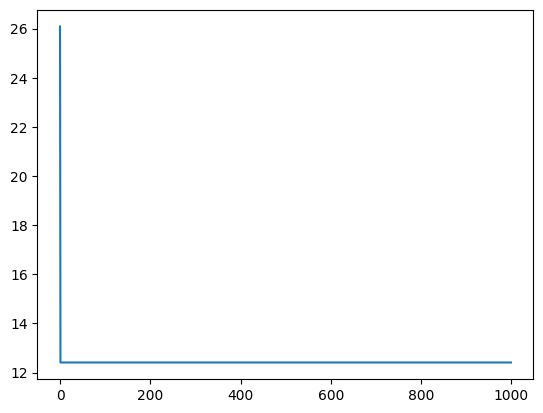

In [34]:
l1 = linear(2, 2)
a1 = relu()
l2 = linear(2, 1)

loss = Loss_CategoricalCrossentropy()
optimizer = optimizer_dgd()

losses = []
for epoch in range(1000):
    # forward
    l1_out = l1.forward(X)
    a1_out = a1.forward(l1_out)
    l2_out = l2.forward(a1_out)
    y_pred = l2_out
    # print(y_pred)

    # calculate loss
    l = loss.calculate(y_pred, y)
    losses.append(l)
    
    # backward
    grad = loss.backward(y_pred, y)
    grad = l2.backward(grad)
    grad = a1.backward(grad)
    grad = l1.backward(grad)
    
    # optimize
    optimizer.step(l1)
    optimizer.step(l2)

# plot loss
plt.plot(losses)
plt.show()



In [37]:
# accuracy


array([[23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29951576],
       [23002.29951576],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29951576],
       [23002.29540023],
       [23002.29951576],
       [23002.29540023],
       [23002.29951576],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29951576],
       [23002.29951576],
       [23002.29540023],
       [23002.29951576],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],
       [23002.29540023],


/tmp/ipykernel_24886/804975396.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_24886/804975396.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


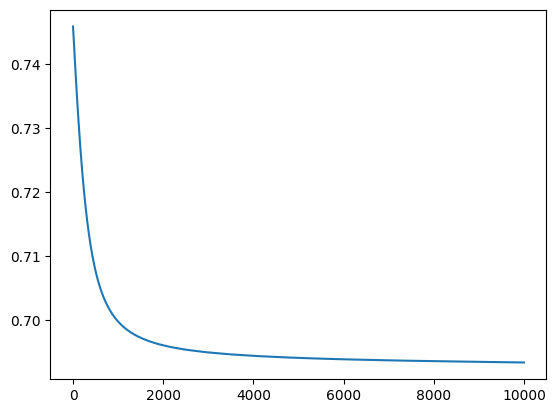

In [162]:
# make same nn with pytorch
import torch
import torch.nn as nn
import torch.optim as optim

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.linear1 = nn.Linear(2, 2)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

    def forward(self, X):
        l1 = self.linear1(X)
        a1 = self.sigmoid(l1)
        l2 = self.linear2(a1)
        a2 = self.sigmoid(l2)
        return a2
    
ann = ANN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(ann.parameters(), lr=0.05)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

losses = []
for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = ann(X)
    l = criterion(y_pred, y)
    losses.append(l.item())
    l.backward()
    optimizer.step()

plt.plot(losses)
plt.show()

In [163]:
# test set
X_test = generate_data(100)
y_test = np.array(np.logical_and(X_test[:, 0], X_test[:, 1]), dtype=int).reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

y_pred = ann(X_test)
print(y_pred)

# accuracy
y_pred = np.array(y_pred.detach().numpy()>0.04, dtype=int)
y_test = np.array(y_test, dtype=int)

acc = np.sum(y_pred==y_test)/len(y_test)
print(acc)

tensor([[0.0424],
        [0.0424],
        [0.0424],
        [0.0424],
        [0.0514],
        [0.0424],
        [0.0514],
        [0.0514],
        [0.0514],
        [0.0374],
        [0.0321],
        [0.0374],
        [0.0321],
        [0.0514],
        [0.0514],
        [0.0424],
        [0.0321],
        [0.0424],
        [0.0321],
        [0.0321],
        [0.0374],
        [0.0514],
        [0.0514],
        [0.0374],
        [0.0514],
        [0.0321],
        [0.0374],
        [0.0374],
        [0.0424],
        [0.0424],
        [0.0514],
        [0.0321],
        [0.0321],
        [0.0321],
        [0.0321],
        [0.0321],
        [0.0374],
        [0.0424],
        [0.0374],
        [0.0514],
        [0.0374],
        [0.0374],
        [0.0374],
        [0.0424],
        [0.0374],
        [0.0514],
        [0.0374],
        [0.0424],
        [0.0424],
        [0.0321],
        [0.0424],
        [0.0321],
        [0.0374],
        [0.0514],
        [0.0424],
        [0

In [164]:
print(y_test)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
